In [1]:
%config Completer.use_jedi = False

import echonet
from echonet.datasets import Echo

import torch.nn.functional as F
from torchvision.models.video import r2plus1d_18
from torch.utils.data import Dataset, DataLoader, Subset
from multiprocessing import cpu_count

from src.utils.torch_utils import TransformDataset, torch_collate
from src.transform_utils import generate_2dmotion_field
from src.loss_functions import huber_loss, convert_to_1hot, convert_to_1hot_tensor
from src.clasfv_losses import deformation_motion_loss, DiceLoss
from src.model.R2plus1D_18_MotionNet import R2plus1D_18_MotionNet
# from src.visualization_utils import categorical_dice

import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim

import random
import pickle
import time

tic, toc = (time.time, time.time)

/opt/anaconda3/envs/dynamic37-labelfusion/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
/opt/anaconda3/envs/dynamic37-labelfusion/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


### Losses for training CLAS-FV using the clips that cover only ED or ES frame

This notebook is a different implementation of CLAS-FV that was described in our paper, "[Fully Automated Multi-heartbeat Echocardiography Video Segmentation and Motion Tracking](http://eg.bucknell.edu/~jvs008/research/cardiac/SPIE22/chenSPIE22_preprint.pdf)." 

Instead of training the CLAS-FV using random 32-frame clips that cover ED-ES systolic sequence, it further relaxes the constraints of a random clip. In this notebook, we can train the CLAS-FV on a clip as long as that clip covers an ED or ES frame with clinical trace.

Most parts are identical to what we have before. Few changes are made to accomodate the fact that only one clinical trace is available for every input video clip.

In [4]:
def categorical_dice(prediction, truth, k, epsilon=1e-5):
    # Dice overlap metric for label value k
    A = (prediction == k)
    B = (truth == k)
    return 2 * np.sum(A * B) / (np.sum(A) + np.sum(B) + epsilon)


def motion_seg_loss(label, label_index, motion_output, seg_softmax, 
                    start=0, end=32, seg_criterion=DiceLoss()):
    r""" Stage 2 loss: SGS is the Shape level segmentation loss and OTS is the Shape level motion tracking loss 
         labels: the data dictionary that contains the key "label_ED" and "label_ES" which is the batch in current implementation 
         shape = N x C x H x W
         motion_output: The output from the motion_tracking head. [N, 4 channel (fore_y, fore_x, back_y, back_x), D, H, W]
         seg_softmax: The output from the segmentation head after torch.argmax() shape = N x C x D x H x W
         omega: 
         weighted: True then weight the dice loss by the inverse of the class size False weight the dice loss equally
    """
    # Frame ED is 1
    # Frame ES is 10
    # From ED to Frame 9 Using motion field 1 - 8. Motion field 1 + frame 1 (ED) = transform frame 2 compare with pred segmented output frame 2
    # Motion field i + transform frame i = transform frame (i + 1) compare with pred segmented output frame (i + 1)
    # flow_source = torch.Tensor(labels["label_ED"]).cuda()
    flow_source = convert_to_1hot(label, 2)
    loss_forward = 0
    count = 0
    
    for frame_index in range(label_index, end - 1):
        forward_motion = motion_output[:, :2, frame_index,...]
        motion_field = generate_2dmotion_field(flow_source, forward_motion)
        next_label = F.grid_sample(flow_source, motion_field, align_corners=False, mode="bilinear", padding_mode='border')
        
        loss_forward += seg_criterion(seg_softmax[:, :, frame_index + 1, ...], next_label)
        flow_source = next_label
        count += 1
        
    # From ES to frame 2 using backward motion field 9 - 2. Motion field 9 + frame 10 (ES) = transform frame 9 compare with pred segmented 9
    # Backward motion field i + transform frame (i + 1) = transform frame i compare with pred segmented i
    # flow_source = torch.Tensor(labels["label_ES"]).cuda()
    flow_source = convert_to_1hot(label, 2)
    loss_backward = 0
    
    # Backward from 9 to 1 
    for frame_index in range(label_index, start, -1):
    #for frame_index in range(motion_output.shape[2] - 2, -1, -1):
        backward_motion = motion_output[:, 2:, frame_index,...]
        motion_field = generate_2dmotion_field(flow_source, backward_motion)
        next_label = F.grid_sample(flow_source, motion_field, align_corners=False, mode="bilinear", padding_mode='border')
        
        loss_backward += seg_criterion(seg_softmax[:, :, frame_index - 1, ...], next_label)
        flow_source = next_label
        count += 1
    
    flow_loss = (loss_forward + loss_backward) / count
    return flow_loss

### Dataset Class and Augmentation Function for generating Random clips that cover ED or ES

In [5]:
def random_start_given_mid_point(mid_point_index, video_length, length=32):
    # TODO: Writing down the code that gives a start point (and end point == start point + length)
    # when giving the video length and 
    # index of the middle point (which must be covered by the start to end video clip)
    if video_length < length:
        return 0, video_length
    possible_start = mid_point_index - length + 1
    possible_end = mid_point_index + 1
    if mid_point_index == 0:
        return 0, 0 + length
    
    if mid_point_index == video_length - 1:
        return video_length - length, video_length
    
    if mid_point_index < length:
        possible_start = 0
    
    if mid_point_index + length > video_length:
        possible_end = video_length - length - 1
    
    if possible_start == possible_end:
        start = possible_start
    else:
        start = np.random.randint(possible_start, possible_end)
        
    end = start + length
    
    return start, end


def zeroone_normalizer(image_data):
    norm_data = image_data
    data_shape = norm_data.shape
    norm_data = norm_data.reshape(3, -1)
    norm_data -= np.min(norm_data, axis=1).reshape(3, 1)
    norm_data /= np.max(norm_data, axis=1).reshape(3, 1)
    norm_data = norm_data.reshape(data_shape)
    
    return norm_data


class EchoNetDynamicDataset(Dataset):
    def __init__(self,
                 image_size=(112, 112), 
                 clip_length=32, 
                 norm=zeroone_normalizer,
                 split='train',
                 subset_indices=None,
                 period=1,
                 **kwargs
                 ):
        
        mean, std = echonet.utils.get_mean_and_std(echonet.datasets.Echo(split=split))
        self.image_size = image_size
        self.clip_length = clip_length
        self.norm = norm
        self.period = period
        # Need filename for saving, and human-selected frames to annotate
        self.echonet_dynamic = echonet.datasets.Echo(split=split,
                                                     target_type=["Filename", "EF", \
                                                                  "LargeIndex", "SmallIndex", \
                                                                  "LargeFrame", "SmallFrame", \
                                                                  "LargeTrace", "SmallTrace"],  
                                                     mean=mean, std=std,  # Normalization
                                                     length=None, max_length=None, period=self.period  # Take all frames
                                                    )
        if subset_indices:
            self.echonet_dynamic = Subset(self.echonet_dynamic, subset_indices)
            
    def __len__(self):
        return len(self.echonet_dynamic)
        
    def __getitem__(self, idx):
        # Get the appropriate info from the Stanford dataset
        whole_video, (filename, EF, es_index, ed_index, es_frame, ed_frame, es_label, ed_label) = self.echonet_dynamic[idx]
        ret_dict = {"filename":EF, 
                    "es_index": es_index, "ed_index": ed_index, 
                    "es_label": es_label, "ed_label": ed_label}
        
        es_index //= self.period
        ed_index //= self.period
        
#         if ed_index > es_index:
#             print("ED and ES comes from different heartbeat")
#             raise Exception
        
        for label_name, mid_point_index in zip(["ed", "es"], [ed_index, es_index]):
            start, end = random_start_given_mid_point(mid_point_index, whole_video.shape[1], length=self.clip_length)
            if start > end:
                raise Exception
            if end - start < self.clip_length:
                # Interpolate (shrink) the ED to ES video
                video = torch.Tensor(whole_video[:, start:end].copy()).unsqueeze(0)
                video = F.interpolate(video, size=(self.clip_length, self.image_size[0], self.image_size[1]), 
                                      mode="trilinear", 
                                      align_corners=False)
                video = video.squeeze().numpy()
                mid_point_clip_index = int(mid_point_index * (self.clip_length / (end - start))) 
            else:
                video = whole_video[:, start:end].copy()
                mid_point_clip_index = mid_point_index - start

            if self.norm:
                video = self.norm(video)
            
            ret_dict[label_name + "_video_clip"] = video
            ret_dict[label_name + "_clip_index"] = mid_point_clip_index
            
        if self.norm:
            es_frame = np.squeeze(self.norm(np.expand_dims(es_frame, 0)))
            ed_frame = np.squeeze(self.norm(np.expand_dims(ed_frame, 0)))
        
        ret_dict["es_frame"] = es_frame
        ret_dict["ed_frame"] = ed_frame
        
        return ret_dict

### Subsetting our Train and Validation Dataset

We exclude the EchoNet videos with no clinically denoted systolic clip or ED-ES duration > 30 frames.

In [6]:
with open("fold_indexes/stanford_train_sampled_indices", "rb") as infile:
    train_mask = pickle.load(infile)
infile.close()

with open("fold_indexes/stanford_valid_sampled_indices", "rb") as infile:
    valid_mask = pickle.load(infile)
infile.close()

### Set up the training and validating dataset
work initialization function is required for generating **random** 32-frame video clip in each training epoch  
Fail to initialize the worker will cause the random 32-frame window to be the **same** for a video during every epoch.

In [7]:
batch_size = 2
num_workers = max(4, cpu_count()//2)

def worker_init_fn_valid(worker_id):                                                          
    np.random.seed(np.random.get_state()[1][0] + worker_id)
    

def worker_init_fn(worker_id):
    # See here: https://pytorch.org/docs/stable/notes/randomness.html#dataloader
    # and the original post of the problem: https://github.com/pytorch/pytorch/issues/5059#issuecomment-817373837
    worker_seed = torch.initial_seed() % 2 ** 32
    np.random.seed(worker_seed)
    random.seed(worker_seed)
    

def permuter(list1, list2):
    for i1 in list1:
        for i2 in list2:
            yield (i1, i2)
            

param_trainLoader = {'collate_fn': torch_collate,
                     'batch_size': batch_size,
                     'num_workers': max(4, cpu_count()//2),
                     'worker_init_fn': worker_init_fn}

param_testLoader = {'collate_fn': torch_collate,
                    'batch_size': batch_size,
                    'shuffle': False,
                    'num_workers': max(4, cpu_count()//2),
                    'worker_init_fn': worker_init_fn}

paramLoader = {'train': param_trainLoader,
               'valid': param_testLoader,
               'test':  param_testLoader}

### Load in the dataset

In [8]:
train_dataset = EchoNetDynamicDataset(split='train', subset_indices=train_mask, period=1)

subset_indices = np.random.choice(np.arange(len(train_dataset)), 3500, replace=False)
train_dataset.echonet_dynamic = Subset(train_dataset.echonet_dynamic, subset_indices)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, 
                              num_workers=num_workers, 
                              shuffle=True, pin_memory=("cuda"), 
                              worker_init_fn=worker_init_fn,
                              drop_last=True)

valid_dataset = EchoNetDynamicDataset(split='val', subset_indices=valid_mask, period=1)

# train_dataset = EchoNetDynamicDataset(split='train', period=1)
# valid_dataset = EchoNetDynamicDataset(split='val', period=1)

valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, 
                              num_workers=num_workers,
                              shuffle=False, pin_memory=("cuda"),
                              worker_init_fn=worker_init_fn_valid
                             )

100%|██████████| 16/16 [00:01<00:00, 14.62it/s]


### Instantiate the CLAS-FV Model

In [9]:
model = torch.nn.DataParallel(R2plus1D_18_MotionNet())
model.to("cuda")

torch.cuda.empty_cache()

print(f'R2+1D MotionNet has {sum(p.numel() for p in model.parameters() if p.requires_grad)} parameters.')

lr_T = 1e-4 
optimizer = optim.Adam(model.parameters(), lr=lr_T)

R2+1D MotionNet has 31575731 parameters.


### Function for training and testing our CLAS-FV Model
Some changes are made to our **train** and **test** function to accomodate the fact that only one labeled frame is avaliable for each train/valid video.

In [10]:
Tensor = torch.cuda.FloatTensor

def train(epoch, train_loader, model, optimizer, loss_func=deformation_motion_loss):
    """ Training function for the network """
    model.train()
    epoch_loss = []
    ed_lv_dice = 0
    es_lv_dice = 0
    
    np.random.seed()
    for batch_idx, batch in enumerate(train_loader, 1):
        ed_video_clips = torch.Tensor(batch["ed_video_clip"])
        ed_video_clips = ed_video_clips.type(Tensor)
        
        es_video_clips = torch.Tensor(batch["es_video_clip"])
        es_video_clips = es_video_clips.type(Tensor)

        optimizer.zero_grad()
        # Get the motion tracking output from the motion tracking head using the feature map
        ed_segmentation_output, ed_motion_output = model(ed_video_clips)
        es_segmentation_output, es_motion_output = model(es_video_clips)
        
        loss = 0
        
        deform_loss = deformation_motion_loss(ed_video_clips, ed_motion_output)
        deform_loss += deformation_motion_loss(es_video_clips, es_motion_output)
        
        loss += deform_loss
        
        flow_loss = 0
        for i in range(ed_video_clips.shape[0]):
            label_ed = np.expand_dims(batch["ed_label"].numpy(), 1).astype("int")
            label_es = np.expand_dims(batch["es_label"].numpy(), 1).astype("int")

            label_ed = label_ed[i]
            label_es = label_es[i]

            label_ed = np.expand_dims(label_ed, 0)
            label_es = np.expand_dims(label_es, 0)

            ed_motion_one_output = ed_motion_output[i].unsqueeze(0)
            ed_segmentation_one_output = ed_segmentation_output[i].unsqueeze(0)

            es_motion_one_output = es_motion_output[i].unsqueeze(0)
            es_segmentation_one_output = es_segmentation_output[i].unsqueeze(0)

            ed_one_index = batch["ed_clip_index"][i]
            es_one_index = batch["es_clip_index"][i]

            flow_one_loss = motion_seg_loss(label_ed,
                                        ed_one_index, 
                                        ed_motion_one_output, ed_segmentation_one_output, 
                                        0, ed_video_clips.shape[2], 
                                        F.binary_cross_entropy_with_logits)
            flow_loss += flow_one_loss

            flow_one_loss = motion_seg_loss(label_es,
                                            es_one_index, 
                                            es_motion_one_output, es_segmentation_one_output, 
                                            0, es_video_clips.shape[2], 
                                            F.binary_cross_entropy_with_logits)
            flow_loss += flow_one_loss
        loss += (flow_loss / ed_video_clips.shape[0] / 2)
                
        ed_segmentations = torch.Tensor([]).type(Tensor)
        es_segmentations = torch.Tensor([]).type(Tensor)
        for i in range(ed_video_clips.shape[0]):
            ed_one_index = batch["ed_clip_index"][i]
            es_one_index = batch["es_clip_index"][i]
            
            ed_seg = ed_segmentation_output[i, :, ed_one_index].unsqueeze(0)
            ed_segmentations = torch.cat([ed_segmentations, ed_seg])
            
            es_seg = es_segmentation_output[i, :, es_one_index].unsqueeze(0)
            es_segmentations = torch.cat([es_segmentations, es_seg])
            
            
        ed_es_seg_loss = 0
        ed_es_seg_loss += F.binary_cross_entropy_with_logits(ed_segmentations, 
                                                             convert_to_1hot(np.expand_dims(batch["ed_label"].numpy().astype("int"), 1), 2), 
                                                             reduction="mean") 
        
        ed_es_seg_loss += F.binary_cross_entropy_with_logits(es_segmentations, 
                                                             convert_to_1hot(np.expand_dims(batch["es_label"].numpy().astype("int"), 1), 2), 
                                                             reduction="mean") 
        ed_es_seg_loss /= 2
        
        loss += ed_es_seg_loss

        loss.backward()
        
        optimizer.step()
        
        epoch_loss.append(loss.item())
        
        ed_segmentation_argmax = torch.argmax(ed_segmentations, 1).cpu().detach().numpy()
        es_segmentation_argmax = torch.argmax(es_segmentations, 1).cpu().detach().numpy()
            
        ed_lv_dice += categorical_dice(ed_segmentation_argmax, batch["ed_label"].numpy(), 1)
        es_lv_dice += categorical_dice(es_segmentation_argmax, batch["es_label"].numpy(), 1)
        
        # Printing the intermediate training statistics
        if batch_idx % 280 == 0:
            print('\nTrain Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * (len(batch["ed_video_clip"]) + len(batch["es_video_clip"])), 
                len(train_loader) * (len(batch["ed_video_clip"]) + len(batch["es_video_clip"])),
                100. * batch_idx / len(train_loader), np.mean(epoch_loss)))

            print("ED LV: {:.3f}".format(ed_lv_dice / batch_idx))
            print("ES LV: {:.3f}".format(es_lv_dice / batch_idx))
            print("Deform loss: ", deform_loss)
            print("Segmentation loss: ", ed_es_seg_loss)
            print("Flow loss: ", flow_loss / (len(batch["ed_video_clip"]) + len(batch["es_video_clip"])))
    
    return epoch_loss


def test(epoch, test_loader, model, optimizer, loss_func=deformation_motion_loss):
    model.eval()
    epoch_loss = []
    ed_lv_dice = 0
    es_lv_dice = 0
    
    for batch_idx, batch in enumerate(test_loader, 1):
        with torch.no_grad():
            ed_video_clips = torch.Tensor(batch["ed_video_clip"])
            ed_video_clips = ed_video_clips.type(Tensor)

            es_video_clips = torch.Tensor(batch["es_video_clip"])
            es_video_clips = es_video_clips.type(Tensor)
        # Get the motion tracking output from the motion tracking head using the feature map
            ed_segmentation_output, ed_motion_output = model(ed_video_clips)
            es_segmentation_output, es_motion_output = model(es_video_clips)
        
        loss = 0
        deform_loss = deformation_motion_loss(ed_video_clips, ed_motion_output)
        deform_loss += deformation_motion_loss(es_video_clips, es_motion_output)
        
        loss += deform_loss
        
        flow_loss = 0
        for i in range(ed_video_clips.shape[0]):
            label_ed = np.expand_dims(batch["ed_label"].numpy(), 1).astype("int")
            label_es = np.expand_dims(batch["es_label"].numpy(), 1).astype("int")

            label_ed = label_ed[i]
            label_es = label_es[i]

            label_ed = np.expand_dims(label_ed, 0)
            label_es = np.expand_dims(label_es, 0)

            ed_motion_one_output = ed_motion_output[i].unsqueeze(0)
            ed_segmentation_one_output = ed_segmentation_output[i].unsqueeze(0)

            es_motion_one_output = es_motion_output[i].unsqueeze(0)
            es_segmentation_one_output = es_segmentation_output[i].unsqueeze(0)

            ed_one_index = batch["ed_clip_index"][i]
            es_one_index = batch["es_clip_index"][i]

            flow_one_loss = motion_seg_loss(label_ed,
                                        ed_one_index, 
                                        ed_motion_one_output, ed_segmentation_one_output, 
                                        0, ed_video_clips.shape[2], 
                                        F.binary_cross_entropy_with_logits)
            flow_loss += flow_one_loss

            flow_one_loss = motion_seg_loss(label_es,
                                            es_one_index, 
                                            es_motion_one_output, es_segmentation_one_output, 
                                            0, es_video_clips.shape[2], 
                                            F.binary_cross_entropy_with_logits)
            flow_loss += flow_one_loss
        loss += (flow_loss / ed_video_clips.shape[0] / 2)
        
        ed_segmentations = torch.Tensor([]).type(Tensor)
        es_segmentations = torch.Tensor([]).type(Tensor)
        for i in range(ed_video_clips.shape[0]):
            ed_one_index = batch["ed_clip_index"][i]
            es_one_index = batch["es_clip_index"][i]
            
            ed_seg = ed_segmentation_output[i, :, ed_one_index].unsqueeze(0)
            ed_segmentations = torch.cat([ed_segmentations, ed_seg])
            
            es_seg = es_segmentation_output[i, :, es_one_index].unsqueeze(0)
            es_segmentations = torch.cat([es_segmentations, es_seg])
            
            
        ed_es_seg_loss = 0
        ed_es_seg_loss += F.binary_cross_entropy_with_logits(ed_segmentations, 
                                                             convert_to_1hot(np.expand_dims(batch["ed_label"].numpy().astype("int"), 1), 2), 
                                                             reduction="mean") 
        
        ed_es_seg_loss += F.binary_cross_entropy_with_logits(es_segmentations, 
                                                             convert_to_1hot(np.expand_dims(batch["es_label"].numpy().astype("int"), 1), 2), 
                                                             reduction="mean") 
        ed_es_seg_loss /= 2
        
        loss += ed_es_seg_loss
        
        epoch_loss.append(loss.item())
        
        ed_segmentation_argmax = torch.argmax(ed_segmentations, 1).cpu().detach().numpy()
        es_segmentation_argmax = torch.argmax(es_segmentations, 1).cpu().detach().numpy()
        
        ed_lv_dice += categorical_dice(ed_segmentation_argmax, batch["ed_label"].numpy(), 1)
        es_lv_dice += categorical_dice(es_segmentation_argmax, batch["es_label"].numpy(), 1)
    
    print("-" * 30 + "Validation" + "-" * 30)
    print("\nED LV: {:.3f}".format(ed_lv_dice / batch_idx))
    print("ES LV: {:.3f}".format(es_lv_dice / batch_idx))
        
        # Printing the intermediate training statistics
        
    print('\nValid set: Average loss: {:.4f}\n'.format(np.mean(epoch_loss)))
    
    return epoch_loss

### Train and Test the CLAS-FV model for eight epochs

In [11]:
Tensor = torch.cuda.FloatTensor

model_save_path = "save_models/ed_or_es_only_R2plus1DMotionSegNet_model_tmp.pth"

train_loss_list = []
valid_loss_list = []

n_epoch = 8
min_loss = 1e5
for epoch in range(1, n_epoch + 1):
    train_dataset = EchoNetDynamicDataset(split='train', subset_indices=train_mask, period=1)
    np.random.seed()
    subset_indices = np.random.choice(np.arange(len(train_dataset)), 3500, replace=False)
    train_dataset.echonet_dynamic = Subset(train_dataset.echonet_dynamic, subset_indices)
    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, 
                                  num_workers=num_workers, 
                                  shuffle=True, pin_memory=("cuda"), 
                                  worker_init_fn=worker_init_fn,
                                  drop_last=True)

    print("-" * 32 + 'Epoch {}'.format(epoch) + "-" * 32)
    start = time.time()
    train_loss = train(epoch, train_loader=train_dataloader, model=model, optimizer=optimizer)
    train_loss_list.append(np.mean(train_loss))
    end = time.time()
    print("training took {:.8f} seconds".format(end-start))
    valid_loss = test(epoch, test_loader=valid_dataloader, model=model, optimizer=optimizer)
    valid_loss_list.append(np.mean(valid_loss))
    
    if (np.mean(valid_loss) < min_loss) and (epoch > 0):
        min_loss = np.mean(valid_loss)
        torch.save({"model": model.state_dict(), "optimizer": optimizer.state_dict()}, model_save_path)

100%|██████████| 16/16 [00:01<00:00, 12.34it/s]


--------------------------------Epoch 1--------------------------------

Train Epoch: 1 [1120/7000 (16%)]	Loss: 0.389828
ED LV: 0.818
ES LV: 0.735
Deform loss:  tensor(0.0194, device='cuda:0', grad_fn=<AddBackward0>)
Segmentation loss:  tensor(0.2224, device='cuda:0', grad_fn=<DivBackward0>)

Train Epoch: 1 [2240/7000 (32%)]	Loss: 0.293236
ED LV: 0.859
ES LV: 0.797
Deform loss:  tensor(0.0191, device='cuda:0', grad_fn=<AddBackward0>)
Segmentation loss:  tensor(0.1175, device='cuda:0', grad_fn=<DivBackward0>)

Train Epoch: 1 [3360/7000 (48%)]	Loss: 0.238341
ED LV: 0.874
ES LV: 0.822
Deform loss:  tensor(0.0148, device='cuda:0', grad_fn=<AddBackward0>)
Segmentation loss:  tensor(0.0989, device='cuda:0', grad_fn=<DivBackward0>)

Train Epoch: 1 [4480/7000 (64%)]	Loss: 0.230678
ED LV: 0.883
ES LV: 0.832
Deform loss:  tensor(0.0292, device='cuda:0', grad_fn=<AddBackward0>)
Segmentation loss:  tensor(0.0828, device='cuda:0', grad_fn=<DivBackward0>)
Flow loss:  tensor(0.0623, device='cuda:0', 

100%|██████████| 16/16 [00:01<00:00, 12.98it/s]


--------------------------------Epoch 2--------------------------------

Train Epoch: 2 [1120/7000 (16%)]	Loss: 0.107148
ED LV: 0.925
ES LV: 0.895
Deform loss:  tensor(0.0187, device='cuda:0', grad_fn=<AddBackward0>)
Segmentation loss:  tensor(0.0537, device='cuda:0', grad_fn=<DivBackward0>)
Flow loss:  tensor(0.0288, device='cuda:0', grad_fn=<DivBackward0>)

Train Epoch: 2 [2240/7000 (32%)]	Loss: 0.101883
ED LV: 0.926
ES LV: 0.896
Deform loss:  tensor(0.0201, device='cuda:0', grad_fn=<AddBackward0>)
Segmentation loss:  tensor(0.0377, device='cuda:0', grad_fn=<DivBackward0>)
Flow loss:  tensor(0.0239, device='cuda:0', grad_fn=<DivBackward0>)

Train Epoch: 2 [3360/7000 (48%)]	Loss: 0.098325
ED LV: 0.926
ES LV: 0.895
Deform loss:  tensor(0.0112, device='cuda:0', grad_fn=<AddBackward0>)
Segmentation loss:  tensor(0.0390, device='cuda:0', grad_fn=<DivBackward0>)
Flow loss:  tensor(0.0180, device='cuda:0', grad_fn=<DivBackward0>)

Train Epoch: 2 [4480/7000 (64%)]	Loss: 0.094079
ED LV: 0.926

100%|██████████| 16/16 [00:01<00:00, 12.87it/s]


--------------------------------Epoch 3--------------------------------

Train Epoch: 3 [1120/7000 (16%)]	Loss: 0.074396
ED LV: 0.928
ES LV: 0.902
Deform loss:  tensor(0.0142, device='cuda:0', grad_fn=<AddBackward0>)
Segmentation loss:  tensor(0.0348, device='cuda:0', grad_fn=<DivBackward0>)
Flow loss:  tensor(0.0152, device='cuda:0', grad_fn=<DivBackward0>)

Train Epoch: 3 [2240/7000 (32%)]	Loss: 0.081168
ED LV: 0.927
ES LV: 0.900
Deform loss:  tensor(0.0224, device='cuda:0', grad_fn=<AddBackward0>)
Segmentation loss:  tensor(0.0432, device='cuda:0', grad_fn=<DivBackward0>)
Flow loss:  tensor(0.0169, device='cuda:0', grad_fn=<DivBackward0>)

Train Epoch: 3 [3360/7000 (48%)]	Loss: 0.077508
ED LV: 0.929
ES LV: 0.902
Deform loss:  tensor(0.0153, device='cuda:0', grad_fn=<AddBackward0>)
Segmentation loss:  tensor(0.0457, device='cuda:0', grad_fn=<DivBackward0>)
Flow loss:  tensor(0.0321, device='cuda:0', grad_fn=<DivBackward0>)

Train Epoch: 3 [4480/7000 (64%)]	Loss: 0.076904
ED LV: 0.929

100%|██████████| 16/16 [00:01<00:00, 12.18it/s]


--------------------------------Epoch 4--------------------------------

Train Epoch: 4 [1120/7000 (16%)]	Loss: 0.069654
ED LV: 0.926
ES LV: 0.901
Deform loss:  tensor(0.0105, device='cuda:0', grad_fn=<AddBackward0>)
Segmentation loss:  tensor(0.0450, device='cuda:0', grad_fn=<DivBackward0>)
Flow loss:  tensor(0.0130, device='cuda:0', grad_fn=<DivBackward0>)

Train Epoch: 4 [2240/7000 (32%)]	Loss: 0.066783
ED LV: 0.929
ES LV: 0.903
Deform loss:  tensor(0.0119, device='cuda:0', grad_fn=<AddBackward0>)
Segmentation loss:  tensor(0.0333, device='cuda:0', grad_fn=<DivBackward0>)
Flow loss:  tensor(0.0120, device='cuda:0', grad_fn=<DivBackward0>)

Train Epoch: 4 [3360/7000 (48%)]	Loss: 0.065584
ED LV: 0.929
ES LV: 0.905
Deform loss:  tensor(0.0092, device='cuda:0', grad_fn=<AddBackward0>)
Segmentation loss:  tensor(0.0536, device='cuda:0', grad_fn=<DivBackward0>)
Flow loss:  tensor(0.0148, device='cuda:0', grad_fn=<DivBackward0>)

Train Epoch: 4 [4480/7000 (64%)]	Loss: 0.064621
ED LV: 0.931

100%|██████████| 16/16 [00:01<00:00, 12.36it/s]


--------------------------------Epoch 5--------------------------------

Train Epoch: 5 [1120/7000 (16%)]	Loss: 0.061328
ED LV: 0.932
ES LV: 0.908
Deform loss:  tensor(0.0156, device='cuda:0', grad_fn=<AddBackward0>)
Segmentation loss:  tensor(0.0170, device='cuda:0', grad_fn=<DivBackward0>)
Flow loss:  tensor(0.0085, device='cuda:0', grad_fn=<DivBackward0>)

Train Epoch: 5 [2240/7000 (32%)]	Loss: 0.061373
ED LV: 0.933
ES LV: 0.908
Deform loss:  tensor(0.0233, device='cuda:0', grad_fn=<AddBackward0>)
Segmentation loss:  tensor(0.0224, device='cuda:0', grad_fn=<DivBackward0>)
Flow loss:  tensor(0.0105, device='cuda:0', grad_fn=<DivBackward0>)

Train Epoch: 5 [3360/7000 (48%)]	Loss: 0.065825
ED LV: 0.931
ES LV: 0.908
Deform loss:  tensor(0.0151, device='cuda:0', grad_fn=<AddBackward0>)
Segmentation loss:  tensor(0.0244, device='cuda:0', grad_fn=<DivBackward0>)
Flow loss:  tensor(0.0242, device='cuda:0', grad_fn=<DivBackward0>)

Train Epoch: 5 [4480/7000 (64%)]	Loss: 0.068825
ED LV: 0.930

100%|██████████| 16/16 [00:01<00:00, 12.23it/s]


--------------------------------Epoch 6--------------------------------

Train Epoch: 6 [1120/7000 (16%)]	Loss: 0.054998
ED LV: 0.936
ES LV: 0.912
Deform loss:  tensor(0.0102, device='cuda:0', grad_fn=<AddBackward0>)
Segmentation loss:  tensor(0.0445, device='cuda:0', grad_fn=<DivBackward0>)
Flow loss:  tensor(0.0196, device='cuda:0', grad_fn=<DivBackward0>)

Train Epoch: 6 [2240/7000 (32%)]	Loss: 0.057608
ED LV: 0.935
ES LV: 0.911
Deform loss:  tensor(0.0073, device='cuda:0', grad_fn=<AddBackward0>)
Segmentation loss:  tensor(0.0405, device='cuda:0', grad_fn=<DivBackward0>)
Flow loss:  tensor(0.0142, device='cuda:0', grad_fn=<DivBackward0>)

Train Epoch: 6 [3360/7000 (48%)]	Loss: 0.059819
ED LV: 0.933
ES LV: 0.909
Deform loss:  tensor(0.0123, device='cuda:0', grad_fn=<AddBackward0>)
Segmentation loss:  tensor(0.0280, device='cuda:0', grad_fn=<DivBackward0>)
Flow loss:  tensor(0.0124, device='cuda:0', grad_fn=<DivBackward0>)

Train Epoch: 6 [4480/7000 (64%)]	Loss: 0.060714
ED LV: 0.932

100%|██████████| 16/16 [00:01<00:00, 13.18it/s]


--------------------------------Epoch 7--------------------------------

Train Epoch: 7 [1120/7000 (16%)]	Loss: 0.058463
ED LV: 0.934
ES LV: 0.910
Deform loss:  tensor(0.0089, device='cuda:0', grad_fn=<AddBackward0>)
Segmentation loss:  tensor(0.0291, device='cuda:0', grad_fn=<DivBackward0>)
Flow loss:  tensor(0.0100, device='cuda:0', grad_fn=<DivBackward0>)

Train Epoch: 7 [2240/7000 (32%)]	Loss: 0.061020
ED LV: 0.933
ES LV: 0.909
Deform loss:  tensor(0.0107, device='cuda:0', grad_fn=<AddBackward0>)
Segmentation loss:  tensor(0.0221, device='cuda:0', grad_fn=<DivBackward0>)
Flow loss:  tensor(0.0084, device='cuda:0', grad_fn=<DivBackward0>)

Train Epoch: 7 [3360/7000 (48%)]	Loss: 0.062301
ED LV: 0.932
ES LV: 0.908
Deform loss:  tensor(0.0099, device='cuda:0', grad_fn=<AddBackward0>)
Segmentation loss:  tensor(0.0348, device='cuda:0', grad_fn=<DivBackward0>)
Flow loss:  tensor(0.0160, device='cuda:0', grad_fn=<DivBackward0>)

Train Epoch: 7 [4480/7000 (64%)]	Loss: 0.062014
ED LV: 0.932

100%|██████████| 16/16 [00:01<00:00, 13.81it/s]


--------------------------------Epoch 8--------------------------------

Train Epoch: 8 [1120/7000 (16%)]	Loss: 0.054686
ED LV: 0.938
ES LV: 0.916
Deform loss:  tensor(0.0101, device='cuda:0', grad_fn=<AddBackward0>)
Segmentation loss:  tensor(0.0239, device='cuda:0', grad_fn=<DivBackward0>)
Flow loss:  tensor(0.0088, device='cuda:0', grad_fn=<DivBackward0>)

Train Epoch: 8 [2240/7000 (32%)]	Loss: 0.056558
ED LV: 0.937
ES LV: 0.914
Deform loss:  tensor(0.0078, device='cuda:0', grad_fn=<AddBackward0>)
Segmentation loss:  tensor(0.0299, device='cuda:0', grad_fn=<DivBackward0>)
Flow loss:  tensor(0.0096, device='cuda:0', grad_fn=<DivBackward0>)

Train Epoch: 8 [3360/7000 (48%)]	Loss: 0.058965
ED LV: 0.935
ES LV: 0.911
Deform loss:  tensor(0.0109, device='cuda:0', grad_fn=<AddBackward0>)
Segmentation loss:  tensor(0.0267, device='cuda:0', grad_fn=<DivBackward0>)
Flow loss:  tensor(0.0094, device='cuda:0', grad_fn=<DivBackward0>)

Train Epoch: 8 [4480/7000 (64%)]	Loss: 0.057740
ED LV: 0.935

### Load the pretrained models

In [13]:
model_save_path = "save_models/ed_or_es_only_R2plus1DMotionSegNet_model_tmp.pth"

model = torch.nn.DataParallel(R2plus1D_18_MotionNet())
model.to("cuda")
torch.cuda.empty_cache()
model.load_state_dict(torch.load(model_save_path)["model"])
print(f'R2+1D MotionNet has {sum(p.numel() for p in model.parameters() if p.requires_grad)} parameters.')

model.eval();

R2+1D MotionNet has 31575731 parameters.


# -----Visualization-----

### Get some echo video clips from Validation Dataset

In [14]:
i = 0
threshold = 34
# threshold = np.random.randint(0, len(valid_dataloader))

np.random.seed()
for data in valid_dataloader:
    i += 1
    data = data
    if i > threshold:
        break

In [15]:
data_dict = data

In [16]:
video = data_dict["ed_video_clip"]

In [17]:
model.eval()
segmentation_output, motion_output = model(torch.Tensor(video))

In [18]:
data_dict["ed_clip_index"], data_dict["es_clip_index"]

(tensor([25,  5]), tensor([12,  2]))

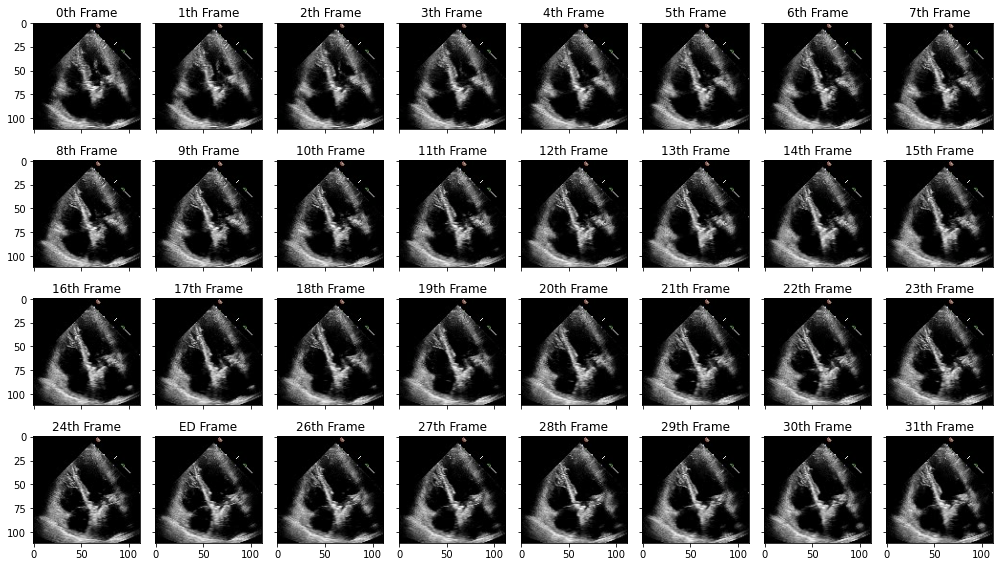

In [19]:
batch_inside_index = 0

fig, ax = plt.subplots(4, 8, figsize=(14, 8), sharex=True, sharey=True)
for i in range(4):
    for j in range(8):
        if i * 8 + j == data_dict["ed_clip_index"][batch_inside_index]:
            ax[i][j].set_title("ED Frame")
        else:
            ax[i][j].set_title("{:d}th Frame".format(i * 8 + j))
        ax[i][j].imshow(video[batch_inside_index, :, i * 8 + j].cpu().detach().numpy().transpose([1, 2, 0]))
        
plt.tight_layout()
plt.show()

In [20]:
%%capture

from src.utils.echo_utils import makeVideo

vid_animation = makeVideo(video.cpu().detach().numpy()[batch_inside_index].transpose([1, 2, 3, 0]))

In [21]:
vid_animation

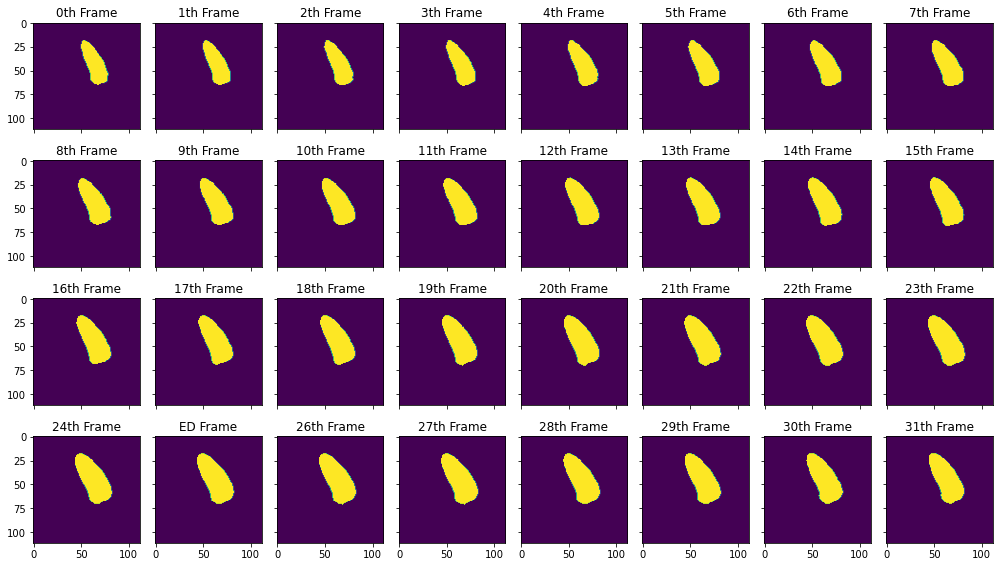

In [22]:
segmentation = torch.argmax(segmentation_output, 1).cpu().detach().numpy()[batch_inside_index]
fig, ax = plt.subplots(4, 8, figsize=(14, 8), sharex=True, sharey=True)
for i in range(4):
    for j in range(8):
        if i * 8 + j == data_dict["ed_clip_index"][batch_inside_index]:
            ax[i][j].set_title("ED Frame")
        else:
            ax[i][j].set_title("{:d}th Frame".format(i * 8 + j))
        ax[i][j].imshow(segmentation[i * 8 + j])
        
plt.tight_layout()
plt.show()

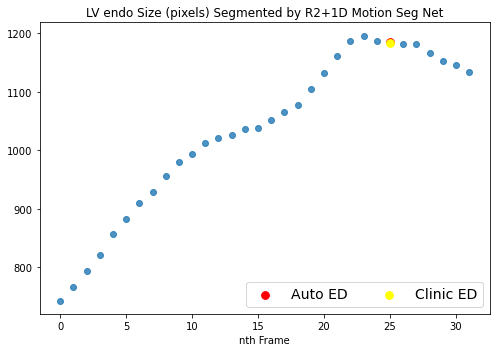

In [23]:
plt.figure(figsize=(7, 5))
lv_sizes = np.sum(segmentation, axis=(1, 2))
plt.scatter(np.arange(32), lv_sizes, alpha=0.8)

plt.scatter(data_dict["ed_clip_index"][batch_inside_index], lv_sizes[data_dict["ed_clip_index"][batch_inside_index]],
            color="red", s=60, label="Auto ED")


plt.title("LV endo Size (pixels) Segmented by R2+1D Motion Seg Net")
plt.xlabel("nth Frame")

plt.scatter(data_dict["ed_clip_index"][batch_inside_index], np.sum(data_dict["ed_label"][batch_inside_index].cpu().detach().numpy()), 
            s=60, color="yellow", label="Clinic ED")
# plt.scatter(es_clip_index[batch_inside_index], np.sum(es_label[batch_inside_index].cpu().detach().numpy()), 
#             s=60, color="black", label="Clinic ES")
# bottom, top = plt.ylim()
# plt.ylim(bottom=200, top=top+200)

plt.legend(loc="lower right", fontsize=14, ncol=2)
plt.tight_layout()
plt.show()

# Full batch of possible random clips
# LV endo sizes cloud

In [ ]:
from src.visualization_utils import get_deformed_label_forback

label_image = {"label_ED": np.expand_dims(np.expand_dims(ed_label[batch_inside_index], 0), 0),
               "label_ES": np.expand_dims(np.expand_dims(es_label[batch_inside_index], 0), 0)}

grid_mode = "bilinear"

flow_source_backward = torch.Tensor(label_image["label_ES"])
es_backwards = [label_image["label_ES"]]
for frame_index in range(es_clip_index[batch_inside_index], ed_clip_index[batch_inside_index], -1):
    motion_field = generate_2dmotion_field(flow_source_backward, motion_output[[batch_inside_index], 2:, frame_index,...])
    new_label = F.grid_sample(flow_source_backward.cuda(), motion_field, align_corners=False, mode=grid_mode, padding_mode='border')
    flow_source_backward = new_label
    if frame_index == ed_clip_index[batch_inside_index] + 1:
        backward_deformed_ed = new_label 
    else:
        es_backwards.append(new_label)
    
flow_source_backward = torch.Tensor(label_image["label_ED"])
ed_backwards = [label_image["label_ED"]]
for frame_index in range(ed_clip_index[batch_inside_index], 0, -1):
    motion_field = generate_2dmotion_field(flow_source_backward, motion_output[[batch_inside_index], 2:, frame_index,...])
    new_label = F.grid_sample(flow_source_backward.cuda(), motion_field, align_corners=False, mode=grid_mode, padding_mode='border')
    flow_source_backward = new_label
    ed_backwards.append(new_label)

flow_source_forward = torch.Tensor(label_image["label_ED"])
ed_forwards = [label_image["label_ED"]]
for frame_index in range(ed_clip_index[batch_inside_index], es_clip_index[batch_inside_index]):
    motion_field = generate_2dmotion_field(flow_source_forward, motion_output[[batch_inside_index], :2, frame_index,...])
    new_label = F.grid_sample(flow_source_forward.cuda(), motion_field, align_corners=False, mode=grid_mode, padding_mode='border')
    flow_source_forward = new_label
    if frame_index == es_clip_index[batch_inside_index] - 1:
        forward_deformed_es = new_label
    else:
        ed_forwards.append(new_label)
    
flow_source_forward = torch.Tensor(label_image["label_ES"])
es_forwards = [label_image["label_ES"]]
for frame_index in range(es_clip_index[batch_inside_index], 31):
    motion_field = generate_2dmotion_field(flow_source_forward, motion_output[[batch_inside_index], :2, frame_index,...])
    new_label = F.grid_sample(flow_source_forward.cuda(), motion_field, align_corners=False, mode=grid_mode, padding_mode='border')
    flow_source_forward = new_label
    es_forwards.append(new_label)

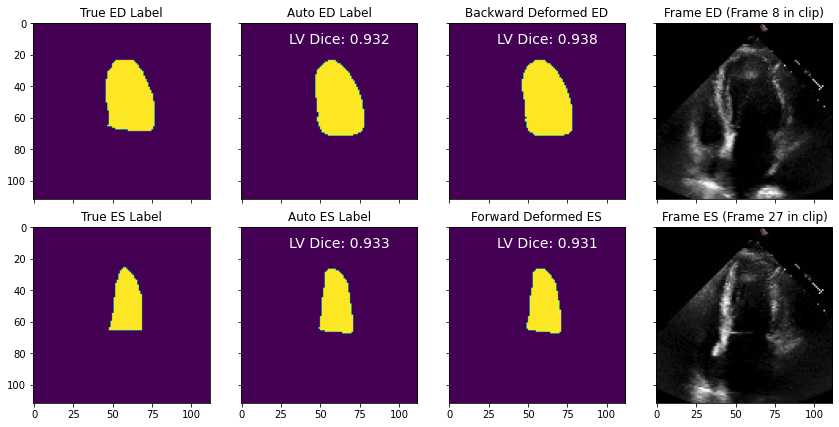

In [19]:
fig, ax = plt.subplots(2, 4, figsize=(12, 6), sharex=True, sharey=True)
ax[0][0].imshow(ed_label[batch_inside_index].numpy())
ax[0][0].set_title("True ED Label")

ax[0][1].imshow(segmentation[ed_clip_index[batch_inside_index]])
ax[0][1].set_title("Auto ED Label")
ax[0][1].text(30, 13, "LV Dice: {:.3f}"
              .format(categorical_dice(ed_label[batch_inside_index].numpy(), 
                                       segmentation[ed_clip_index[batch_inside_index]], 1)),
             color="white", fontsize=14)

backward_deformed_ed[backward_deformed_ed > 0.05] = 1
ax[0][2].set_title("Backward Deformed ED")
ax[0][2].imshow(backward_deformed_ed[0, 0].cpu().detach().numpy())
ax[0][2].text(30, 13, "LV Dice: {:.3f}"
              .format(categorical_dice(ed_label[batch_inside_index].numpy(), 
                                       backward_deformed_ed[0, 0].cpu().detach().numpy(), 1)),
              color="white", fontsize=14)

ax[0][3].imshow(video[batch_inside_index, :, ed_clip_index[batch_inside_index]].numpy().transpose([1, 2, 0]))
ax[0][3].set_title("Frame ED (Frame {:d} in clip)".format(ed_clip_index[batch_inside_index]))

ax[1][0].imshow(es_label[batch_inside_index].numpy())
ax[1][0].set_title("True ES Label")

ax[1][1].imshow(segmentation[es_clip_index[batch_inside_index]])
ax[1][1].set_title("Auto ES Label")
ax[1][1].text(30, 13, "LV Dice: {:.3f}"
              .format(categorical_dice(es_label[batch_inside_index].numpy(), 
                                       segmentation[es_clip_index[batch_inside_index]], 1)),
             color="white", fontsize=14)

forward_deformed_es[forward_deformed_es > 0.05] = 1
ax[1][2].set_title("Forward Deformed ES")
ax[1][2].imshow(forward_deformed_es[0, 0].cpu().detach().numpy())
ax[1][2].text(30, 13, "LV Dice: {:.3f}"
              .format(categorical_dice(es_label[batch_inside_index].numpy(), 
                                       forward_deformed_es[0, 0].cpu().detach().numpy(), 1)),
              color="white", fontsize=14)

ax[1][3].imshow(video[batch_inside_index, :,es_clip_index[batch_inside_index]].numpy().transpose([1, 2, 0]))
ax[1][3].set_title("Frame ES (Frame {:d} in clip)".format(es_clip_index[batch_inside_index]))

plt.tight_layout()
plt.show()

Forward Deformation


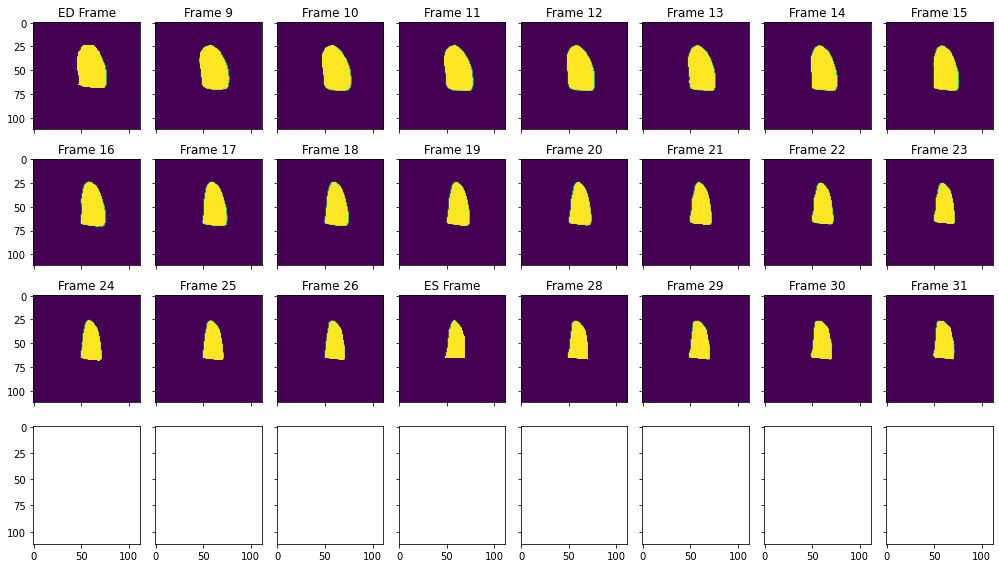

In [20]:
print("Forward Deformation")

forward_deformation = ed_forwards + es_forwards 
fig, ax = plt.subplots(4, 8, figsize=(14, 8), sharex=True, sharey=True)
for i in range(4):
    for j in range(8):
        if i * 8 + j >= len(forward_deformation):
            continue
        if i + j == 0:
            ax[i][j].set_title("ED Frame")
        elif i * 8 + j == len(ed_forwards):
            ax[i][j].set_title("ES Frame")
        else:
            ax[i][j].set_title("Frame {:d}".format(i * 8 + j + ed_clip_index[batch_inside_index]))
        try:
            ax[i][j].imshow(forward_deformation[i * 8 + j][0, 0].cpu().detach().numpy())
        except:
            ax[i][j].imshow(forward_deformation[i * 8 + j][0, 0])
        
plt.tight_layout()
plt.show()

Backward Deformation


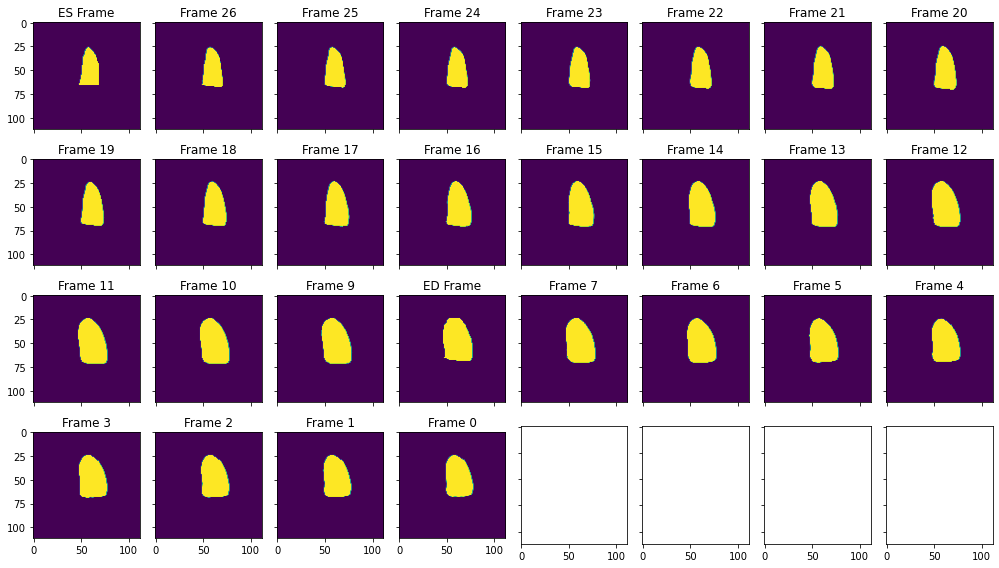

In [21]:
print("Backward Deformation")

backward_deformation = es_backwards + ed_backwards 
fig, ax = plt.subplots(4, 8, figsize=(14, 8), sharex=True, sharey=True)
for i in range(4):
    for j in range(8):
        if i * 8 + j >= len(backward_deformation):
            continue
        if i + j == 0:
            ax[i][j].set_title("ES Frame")
        elif i * 8 + j == len(es_backwards):
            ax[i][j].set_title("ED Frame")
        else:
            ax[i][j].set_title("Frame {:d}".format(es_clip_index[batch_inside_index] - i * 8 - j))
        try:
            ax[i][j].imshow(backward_deformation[i * 8 + j][0, 0].cpu().detach().numpy())
        except:
            ax[i][j].imshow(backward_deformation[i * 8 + j][0, 0])
        
plt.tight_layout()
plt.show()